# Imports and files

In [1]:
from pathlib import Path

import pandas as pd

from sainsc import read_StereoSeq

In [2]:
data_path = Path("data")
analysis_path = Path("brain")

stereo_seq_file = data_path / "StereoSeq" / "Mouse_brain_Adult_GEM_bin1.tsv.gz"

signature_file = Path(".") / "yao_brain_signatures_log.tsv"

de_genes_file = data_path / "yao_2021" / "DE_genes_yao2021.xlsx"

In [3]:
analysis_path.mkdir(exist_ok=True, parents=True)

In [4]:
genes = (
    pd.read_excel(
        de_genes_file, sheet_name="5981_DE_genes", header=None, names=["gene"]
    )
    .loc[:, "gene"]
    .tolist()
)

# Determine usable area

This is probably easier done while reading the file binned which is much faster

In [5]:
stereo = read_StereoSeq(stereo_seq_file, resolution=500, n_threads=16)

print(stereo)

LazyKDE (16 threads)
    genes: 26177
    shape: (10500, 13950)
    resolution: 500.0 nm / px


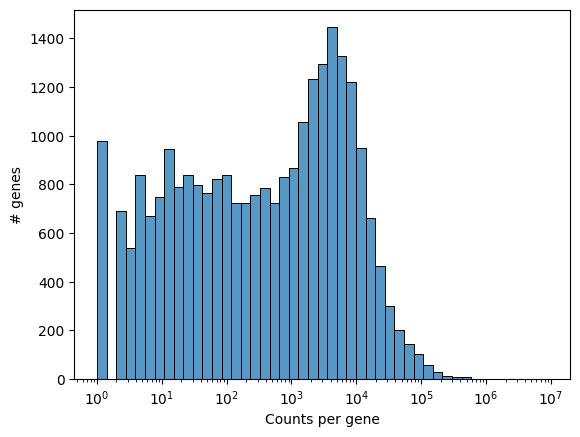

In [11]:
_ = stereo.plot_genecount_histogram()

In [6]:
stereo.gaussian_kernel(8)

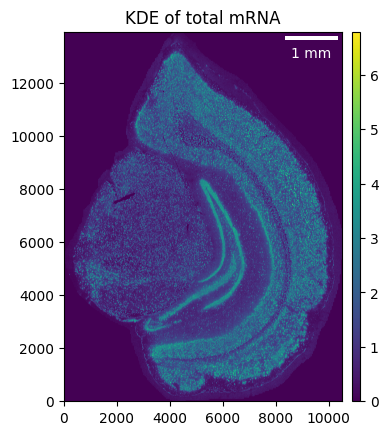

In [7]:
stereo.calculate_total_mRNA()
stereo.calculate_total_mRNA_KDE()

_ = stereo.plot_KDE()

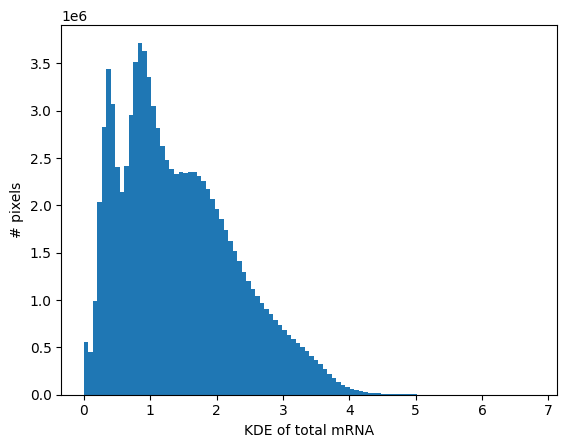

In [39]:
_ = stereo.plot_KDE_histogram(bins=100)

In [8]:
stereo.filter_background(1.3)

In [9]:
signatures = pd.read_table(signature_file, index_col=0).loc[
    lambda df: df.index.isin(genes) & df.index.isin(stereo.genes)
]

signatures.shape

(5936, 42)

In [10]:
import json

import colorcet as cc
import seaborn as sns

cmap = dict(
    zip(
        signatures.columns,
        sns.color_palette(cc.glasbey, n_colors=len(signatures.columns)),
    )
)

with open("colormap_brain.json", "w") as f:
    json.dump(cmap, f)

## Celltype assignment

In [11]:
stereo.assign_celltype(signatures, log=True)

print(stereo)

LazyKDE (16 threads)
    genes: 26177
    shape: (10500, 13950)
    resolution: 500.0 nm / px
    kernel: (33, 33)
    background: set
    celltypes: 42


### thresholding

In [4]:
kde_per_celltype = pd.DataFrame(
    {
        "kde": stereo.total_mRNA_KDE.flatten(),
        "celltype": pd.Categorical.from_codes(
            stereo.celltype_map.flatten(), categories=stereo.celltypes
        ),
    }
).dropna()

celltype_threshold = (
    kde_per_celltype.groupby("celltype", observed=True).quantile(0.8)["kde"] / 3
).to_dict()

min_t = 0.7

celltype_threshold = {
    ct: (t if t > min_t else min_t) for ct, t in celltype_threshold.items()
}

stereo.filter_background(celltype_threshold)

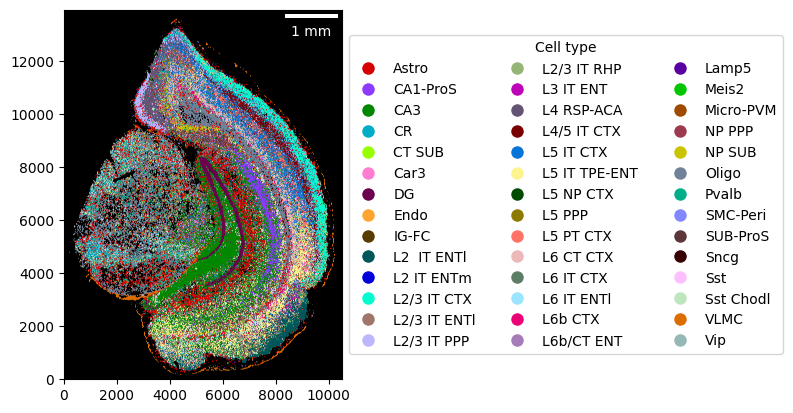

In [8]:
fig = stereo.plot_celltypemap(remove_background=True, cmap=cmap)

## Layering

In [5]:
import colorcet as cc
import seaborn as sns

layers = [
    "L2/3 IT CTX",
    "L4/5 IT CTX",
    "L5 IT CTX",
    "L5 PT CTX",
    "L6 CT CTX",
    "L6 IT CTX",
    "L6b CTX",
    "L2  IT ENTl",
    "L2/3 IT ENTl",
    "L3 IT ENT",
    "L5 IT TPE-ENT",
    "L6b/CT ENT",
    "VLMC",
]
layer_cmap = dict(zip(layers, sns.color_palette(cc.glasbey, n_colors=len(layers))))

In [8]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib_scalebar.scalebar import ScaleBar

plt.ioff()

ncol = 7

fig = plt.figure(figsize=(15, 5))
subfigs = fig.subfigures(1, 2, width_ratios=[1, 3.5])

f = stereo.plot_celltypemap(remove_background=True, cmap=layer_cmap, background="white")
im = f.axes[0]._children[0].get_array()
ax = subfigs[0].subplots()
ax.imshow(im, origin="lower")
ax.set_axis_off()
_ = ax.add_artist(
    ScaleBar(500, **{"units": "nm", "box_alpha": 0, "location": "upper right"})
)

axs = subfigs[1].subplots(2, ncol)

legend_elements = [
    Line2D([0], [0], marker="o", color="w", label=lbl, markerfacecolor=c, markersize=10)
    for lbl, c in layer_cmap.items()
]

axs[1, 0].legend(
    title="Cell type", handles=legend_elements, ncols=1, frameon=False, prop={"size": 7}
)
axs[1, 0].set_axis_off()

for i, ct in enumerate(layers):
    im = stereo.plot_celltypemap(
        remove_background=True, cmap={ct: "red"}, background="white", return_img=True
    )
    j = i // ncol
    i = i % ncol
    if j == 1:
        i += 1
    axs[j, i].imshow(im, origin="lower")
    axs[j, i].set_axis_off()
    axs[j, i].set(title=ct)

_ = axs[0, 0].add_artist(
    ScaleBar(500, **{"units": "nm", "box_alpha": 0, "location": "upper right"})
)

fig.tight_layout()

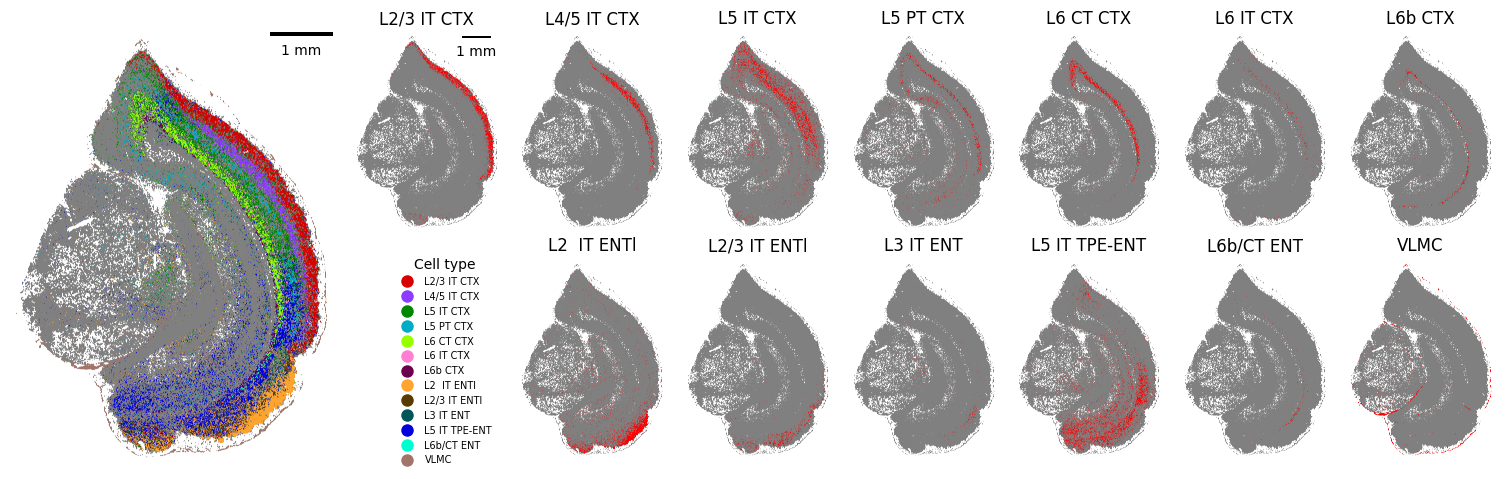

In [9]:
fig

In [7]:
fig.savefig("figures/Fig_Cortex_layers.pdf", dpi=600)